In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

/var/folders/p3/184hg1h95psd8k39s1mht5jw0000gn/T/ipykernel_17455/2273399179.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("/Users/sohamshrivastava/Library/CloudStorage/OneDrive-iitgn.ac.in/disk D items iii/college/semester 3/Machine learning/Assignment 2/es335-24-fall-assignment-2/WhatsApp Image 2024-09-20 at 17.39.59.jpeg")
print(img.shape)

torch.Size([3, 698, 1280])


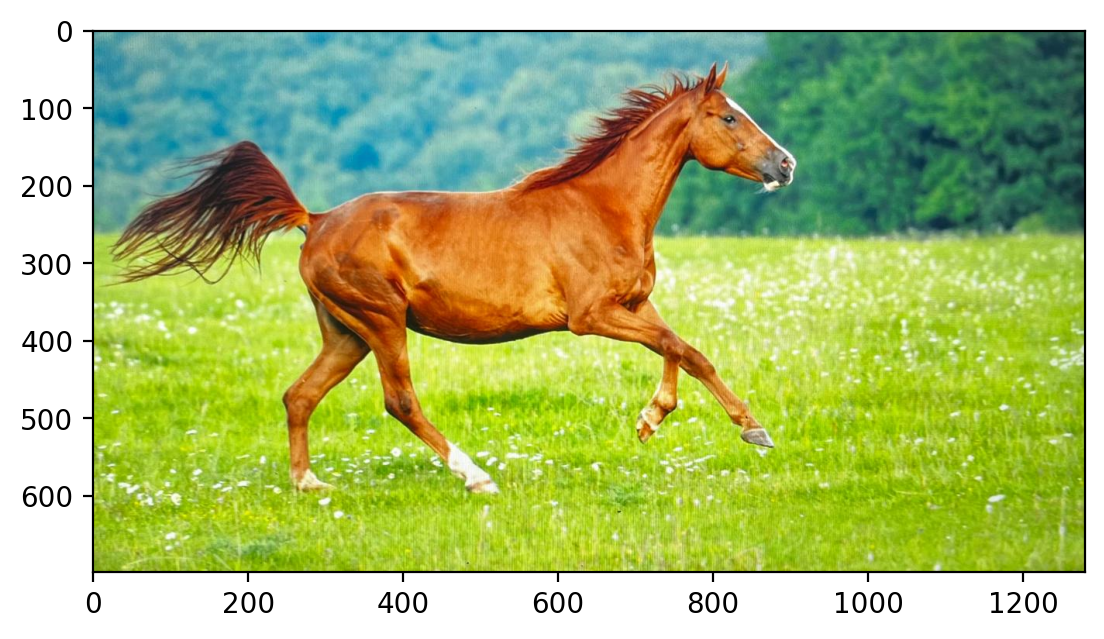

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img



MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3412, 0.3529, 0.3333,  ..., 0.1882, 0.1804, 0.1765],
         [0.3373, 0.3569, 0.3451,  ..., 0.1882, 0.1804, 0.1765],
         [0.3333, 0.3608, 0.3569,  ..., 0.1922, 0.1804, 0.1804],
         ...,
         [0.5176, 0.5137, 0.5059,  ..., 0.5373, 0.5608, 0.5725],
         [0.4863, 0.5020, 0.5137,  ..., 0.5529, 0.5529, 0.5294],
         [0.4745, 0.4902, 0.5059,  ..., 0.5647, 0.5608, 0.5373]],

        [[0.6118, 0.6235, 0.6039,  ..., 0.4039, 0.3961, 0.3922],
         [0.6078, 0.6275, 0.6157,  ..., 0.4039, 0.3961, 0.3922],
         [0.5961, 0.6235, 0.6196,  ..., 0.4039, 0.3961, 0.3961],
         ...,
         [0.6824, 0.6784, 0.6667,  ..., 0.6431, 0.6549, 0.6667],
         [0.6510, 0.6706, 0.6745,  ..., 0.6667, 0.6549, 0.6275],
         [0.6431, 0.6588, 0.6667,  ..., 0.6784, 0.6627, 0.6353]],

        [[0.6392, 0.6510, 0.6314,  ..., 0.3137, 0.3059, 0.3020],
         [0.6353, 0.6549, 0.6431,  ..., 0.3137, 0.3059, 0.3020],
         [0.6196, 0.6471, 0.6431,  ..., 0.3137, 0.3059, 0.

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 0, 700, 300, 300)
crop.shape

torch.Size([3, 300, 300])

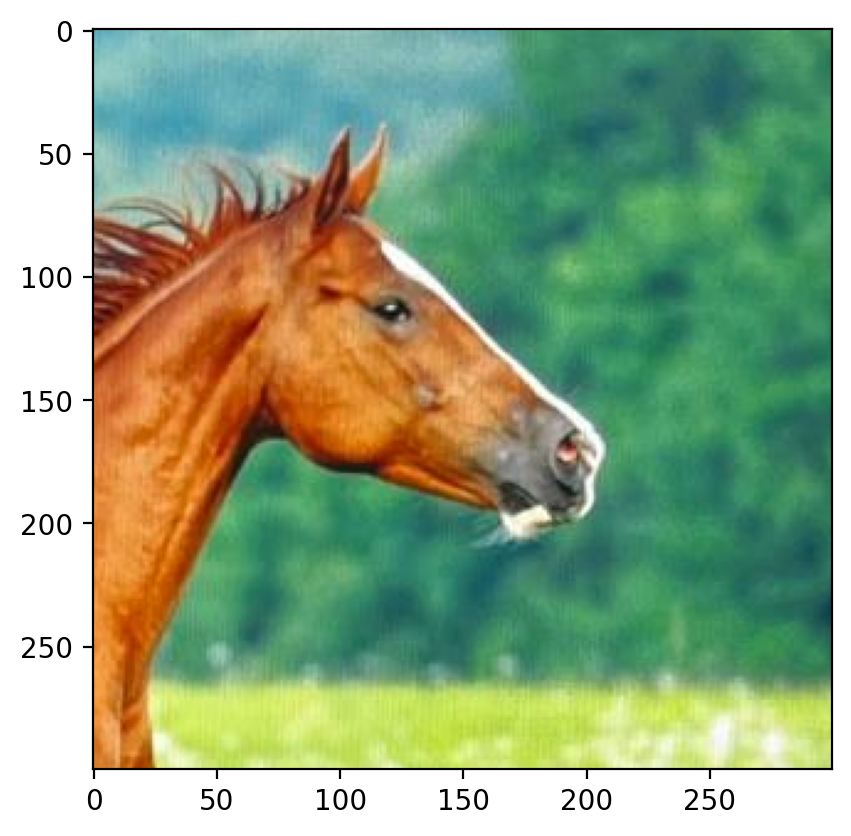

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [10]:
crop = crop.to(device)

In [11]:
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [12]:
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [13]:
X.shape

torch.Size([90000, 2])

In [14]:
import torch
import numpy as np

def mask_block(image_tensor, block_size=(30, 30), top_left=None):
    C, H, W = image_tensor.shape
    block_height, block_width = block_size
    
    if top_left is None:
        top = np.random.randint(0, H - block_height + 1)
        left = np.random.randint(0, W - block_width + 1)
    else:
        top, left = top_left
    mask = torch.ones(H, W, dtype=torch.bool)
    mask[top:top + block_height, left:left + block_width] = False
    masked_image = image_tensor.clone()
    for c in range(C):
        masked_image[c] = torch.where(mask, image_tensor[c], torch.tensor(0.0))
    
    return masked_image, mask

masked_image, mask = mask_block(crop, block_size=(30, 30))


In [15]:
def create_coordinate_map(masked_image):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = masked_image.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(masked_image, 'c h w -> (h w) c').float()
    return X, Y

In [16]:
img_X, img_Y = create_coordinate_map(masked_image)
img_X.shape, img_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [17]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [18]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [19]:
net = LinearModel(2, 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [20]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [21]:
train(net, 0.01, img_X_scaled, img_Y, 1000)

Epoch 0 loss: 1.038510
Epoch 100 loss: 0.068146
Epoch 200 loss: 0.035764
Epoch 300 loss: 0.035652
Epoch 400 loss: 0.035652
Epoch 500 loss: 0.035652
Epoch 600 loss: 0.035652
Epoch 700 loss: 0.035652
Epoch 800 loss: 0.035652
Epoch 900 loss: 0.035652


0.03565225377678871

In [22]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)  

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Plot reconstructed image
    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    
    # Plot original image
    ax1.imshow(original_img.cpu().permute(1, 2, 0))  
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()


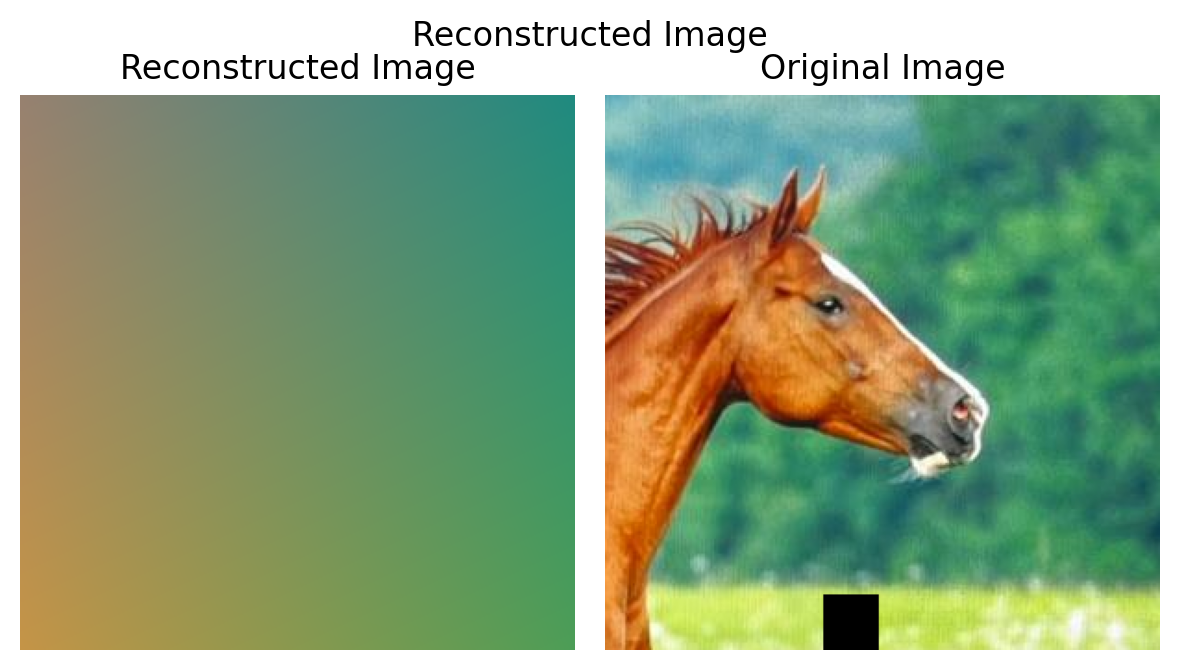

In [23]:
plot_reconstructed_and_original_image(masked_image, net, img_X_scaled, title="Reconstructed Image")

In [24]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [25]:
X_rff = create_rff_features(img_X_scaled, 10000, 0.008)

In [26]:
X_rff.shape

torch.Size([90000, 10000])

In [27]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, img_Y, 2500)

Epoch 0 loss: 0.268082
Epoch 100 loss: 0.041645
Epoch 200 loss: 0.026960
Epoch 300 loss: 0.024348
Epoch 400 loss: 0.022673


KeyboardInterrupt: 

In [ ]:
Y = plot_reconstructed_and_original_image(masked_image, net, X_rff, title="Reconstructed Image with RFF Features")


In [ ]:
def calculate_rmse(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2)
    rmse = torch.sqrt(mse)
    return rmse

def calculate_psnr(original, reconstructed):
    rmse = calculate_rmse(original, reconstructed)
    if rmse == 0:
        return float('inf')
    psnr = 20 * torch.log10(torch.tensor(1.0) / rmse)
    return psnr

with torch.no_grad():
    reconstructed = net(X_rff) 
    reconstructed = rearrange(reconstructed, '(h w) c -> c h w', h=masked_image.shape[1], w=masked_image.shape[2])

rmse_value = calculate_rmse(masked_image, reconstructed)
psnr_value = calculate_psnr(masked_image, reconstructed)

print(f"RMSE by RFF: {rmse_value.item():.6f}")
print(f"PSNR by RFF: {psnr_value.item():.6f}")
